In [9]:
import os
from openmm.app import *
from openmm import *
from simtk.unit import *
import MDAnalysis as md
import nglview as ng
from sys import stdout
import numpy as np
import matplotlib.pyplot as plt

In [10]:
pdb0_file = '../../../data/md_example/md_tutorial/villin_water.pdb'
pdb1_file = '../../../data/md_example/md_tutorial/polyALA.pdb'
pdb2_file = '../../../data/md_example/md_tutorial/polyGLY.pdb'
pdb3_file = '../../../data/md_example/md_tutorial/polyGV.pdb'

In [11]:
# show original polyGV
ng.show_mdanalysis(md.Universe(pdb3_file), gui=True)

NGLWidget()

In [12]:
### 1.loading initial coordinates
pdb = PDBFile(pdb3_file)

### 2.choosing a forcefield parameters
ff = ForceField('amber10.xml')
system = ff.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic)

### 3. Choose parameters of the experiment: temperature, pressure, box size, solvation, boundary conditions, etc
temperature = 300 * kelvin
frictionCoeff = 1 / picosecond
time_step = 0.002 * picoseconds
total_steps = 400 * picoseconds / time_step

### 4. Choose an algorithm (integrator)
integrator = LangevinIntegrator(temperature, frictionCoeff, time_step)

### 5. Run simulation, saving coordinates time to time:

### 5a. Create a simulation object
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

### 5b. Minimize energy
simulation.minimizeEnergy()

### 5c. Save coordinates to dcd file and energies to a standard output console:
out_file = '../../../data/md_example/md_tutorial/output/polyALA_traj.dcd' 
if os.path.exists(out_file):
    os.remove(out_file)

fp = open(out_file, 'w')
fp.close()
simulation.reporters.append(DCDReporter(out_file, 1000))  # 1000 is the interval at which to write frames
simulation.reporters.append(StateDataReporter(stdout, 5000, step=True, potentialEnergy=True,\
                                              temperature=True, progress=True, totalSteps = total_steps))

### 5d. Run!
simulation.step(total_steps)

#"Progress (%)","Step","Potential Energy (kJ/mole)","Temperature (K)"
2.5%,5000,3831.74853515625,306.4389492155022
5.0%,10000,3759.711669921875,292.5373620565675
7.5%,15000,3687.43994140625,303.22380731154107
10.0%,20000,3695.89208984375,304.4838208480849
12.5%,25000,3657.02978515625,322.236145904221
15.0%,30000,3651.638671875,302.381911815255
17.5%,35000,3552.4951171875,299.18669064139164
20.0%,40000,3439.857421875,286.22360574160285
22.5%,45000,3501.42822265625,315.28263935743524
25.0%,50000,3292.4921875,299.7249431774265
27.5%,55000,3360.16748046875,295.20102702922
30.0%,60000,3241.711669921875,298.4750126067865
32.5%,65000,3043.74755859375,303.06013436655417
35.0%,70000,3065.77294921875,307.97103295709246
37.5%,75000,3047.62939453125,311.5690170585662
40.0%,80000,3053.60791015625,299.1807838858625
42.5%,85000,3059.68701171875,306.9072090508103
45.0%,90000,3040.349609375,311.82266781858544
47.5%,95000,2996.052001953125,282.90874366091
50.0%,100000,3007.74560546875,292.481278116625
5

In [13]:
### 6. Visualization
sys = md.Universe(pdb3_file, out_file)
ng.show_mdanalysis(sys, gui=True)

NGLWidget(max_frame=199)

In [21]:
### analysis of end-to-end distance

## choose terminal atoms
N_terminus = sys.select_atoms('resid 1 and name N')  # topology 是 pdb3_file 文件, 里面有残基编号和原子名称
C_terminus = sys.select_atoms('resid 25 and name C')

print(N_terminus.positions)
print(C_terminus.positions)

## go through the whole trajectory and compute distance between them for every frame
# 为什么 N_terminus.positions - C_terminus.positions 会在每次循环有不同的值? 猜测可能是因为 N_terminus 和 C_terminus 是一个指针
dist = []
for frame in sys.trajectory:
    dist.append(np.linalg.norm(N_terminus.positions - C_terminus.positions))

## the result is in the dist array
dist = np.array(dist)
print(dist.shape)
print(dist[:3])

[[-37.03486   -28.459978   -3.9018335]]
[[30.037119 19.253273  2.593093]]
(200,)
[82.567474 74.64717  75.07525 ]


In [24]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

## compute information about hbonds and write it to the 'hb.timeseries'
hb = HBA(
  universe=sys,
  donors_sel='resname VAL',
  hydrogens_sel='resname ALA1 ALA7 and name H1 H2 H3 H',
  acceptors_sel='resname ALA2 ALA5 and name O',
  d_h_cutoff=1.2
)
hb.run()

# ## print information for the first 10 frames
# for frame in hb.timeseries[:10]:
#     print(frame)

print(hb.results.hbonds)

[]


In [25]:
## go through the 'hb.timeseries' file and calculate number of bonds for each time frame
## (it's the length of array frame)
hb_number = []
for frame in hb.timeseries:
    hb_number.append(len(frame))

## the result is in the number array
hb_number = np.array(hb_number)

AttributeError: 'HydrogenBondAnalysis' object has no attribute 'timeseries'

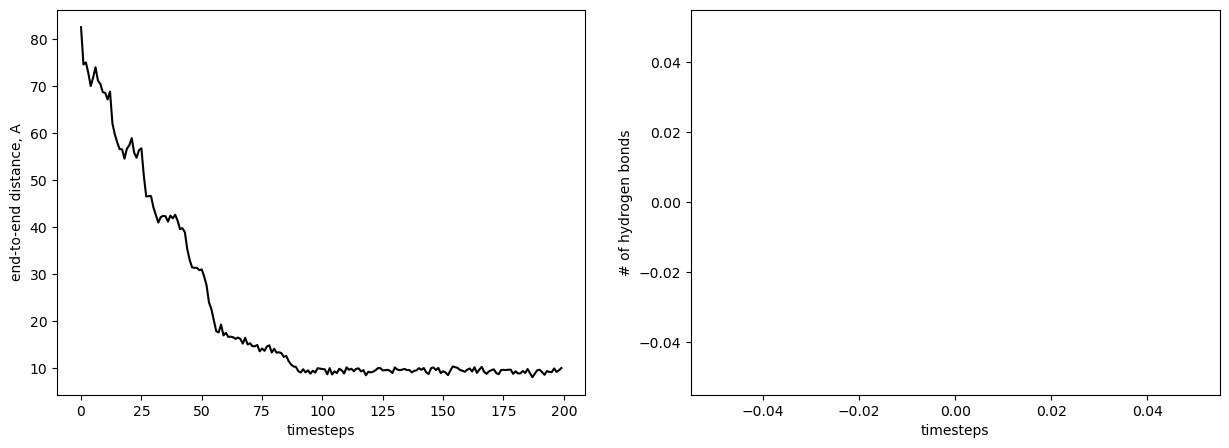

In [28]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(dist, '-k')
plt.xlabel('timesteps')
plt.ylabel('end-to-end distance, A')

plt.subplot(122)
plt.plot(hb_number, 'g-')
plt.ylabel('# of hydrogen bonds')
plt.xlabel('timesteps')

plt.show()

/Users/jerrykwan/anaconda3/envs/temp/lib/python3.9/site-packages/MDAnalysis/analysis/dihedrals.py:422: UserWarning: Cannot determine phi and psi angles for the first or last residues
  warnings.warn("Cannot determine phi and psi angles for the first "


Text(30, 150, 'beta region')

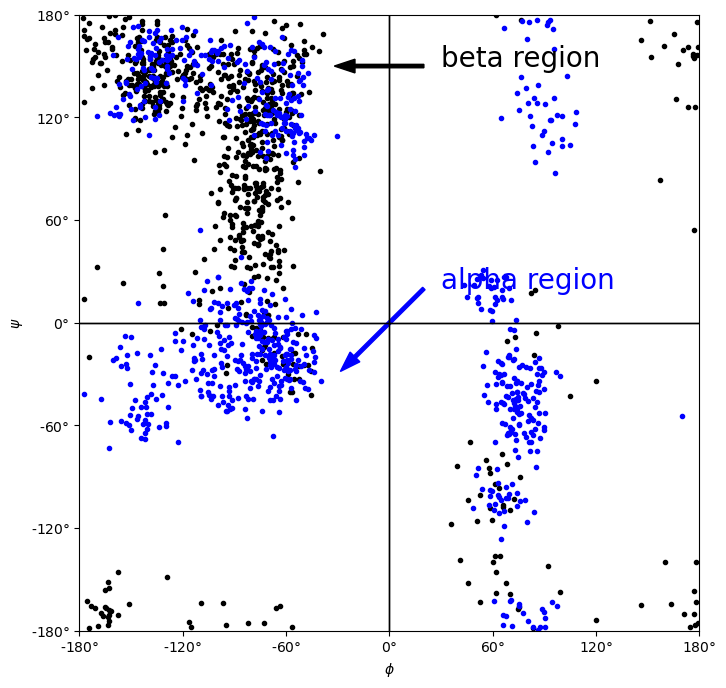

In [29]:
from MDAnalysis.analysis import dihedrals  ## module for dihedrals analysis

ram1 = dihedrals.Ramachandran(sys).run(0, 30)  ## analyse for first 30 steps (black color)
ram2 = dihedrals.Ramachandran(sys).run(170, 200)  ## analyse for last 30 steps (blue color)
print(ram1)
print(ram2)

## ramachandran plot
fig, ax = plt.subplots(figsize=(8, 8))
ram1.plot(ax=ax, color='k', marker='.')
ram2.plot(ax=ax, color='b', marker='.')
ax.arrow(20, 20, -40, -40, width=2, head_width=8, head_length=12, fc='b', ec='b')
ax.text(30, 20, 'alpha region', color='blue', fontsize=20)
ax.arrow(20, 150, -40, 0, width=2, head_width=8, head_length=12, fc='k', ec='k')
ax.text(30, 150, 'beta region', fontsize=20)